<span style="font-size: 24px;">Data Cleaning</span>


In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# brands.csv
brands = pd.read_csv("b_cl.csv")

# orders.csv
orders = pd.read_csv("orders_final.csv")

# orderlines.csv
orderlines = pd.read_csv("orderlines_final.csv")

# products.csv
products = pd.read_csv("products_final.csv")

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)
pd.set_option('max_colwidth', 400)


o_cl = orders.copy()
ol_cl = orderlines.copy()
p_cl = products.copy()
b_cl = brands.copy()

In [61]:
ol_cl["date"] = pd.to_datetime(ol_cl["date"])

In [62]:
o_cl["created_date"] = pd.to_datetime(o_cl["created_date"])

<span style="font-size: 30px;">Data Analysis</span>

In [63]:
# discount flag to the orderlines table
ol_cl['has_discount'] = ol_cl['discount_pct'] > 0  


In [64]:
#  products with and without discounts groupping by sku and total number of quantitiy
no_discount = ol_cl[ol_cl['has_discount'] == False].groupby('sku')['qty'].sum().rename('qty_no_discount')
with_discount = ol_cl[ol_cl['has_discount'] == True].groupby('sku')['qty'].sum().rename('qty_with_discount')

# joining the results into a new dataframe
product_comparison = pd.DataFrame({'qty_no_discount': no_discount, 'qty_with_discount': with_discount})

# products that were never discounted or only sold with discounts
product_comparison = product_comparison.fillna(0)

# creating the discount impact column
product_comparison['discount_impact'] = product_comparison['qty_with_discount'] / (product_comparison['qty_no_discount'] + 1)

# top 10 products that sell much better with discounts
discount_sensitive = product_comparison.sort_values('discount_impact', ascending=False).head(5)

In [65]:
discount_sensitive

,qty_no_discount,qty_with_discount,discount_impact
sku,,,
LAC0181,0.00,222.00,222.00
ZAG0030,0.00,193.00,193.00
MAC0144,0.00,188.00,188.00
CRU0017-2,0.00,180.00,180.00
JAW0048,0.00,162.00,162.00


In [66]:
# adding month column to see seasonal patterns
ol_cl['month'] = ol_cl['date'].dt.month_name()

#ordering months in correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
ol_cl['month'] = pd.Categorical(ol_cl['month'], categories=month_order, ordered=True)

# relation between monthly sales and average discount for these sensitive products
seasonal_patterns = ol_cl[ol_cl['sku'].isin(discount_sensitive.index)].groupby(
    ['category', 'month']
).agg({
    'qty': 'sum',
    'discount_pct': 'mean'
}).reset_index()



In [67]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

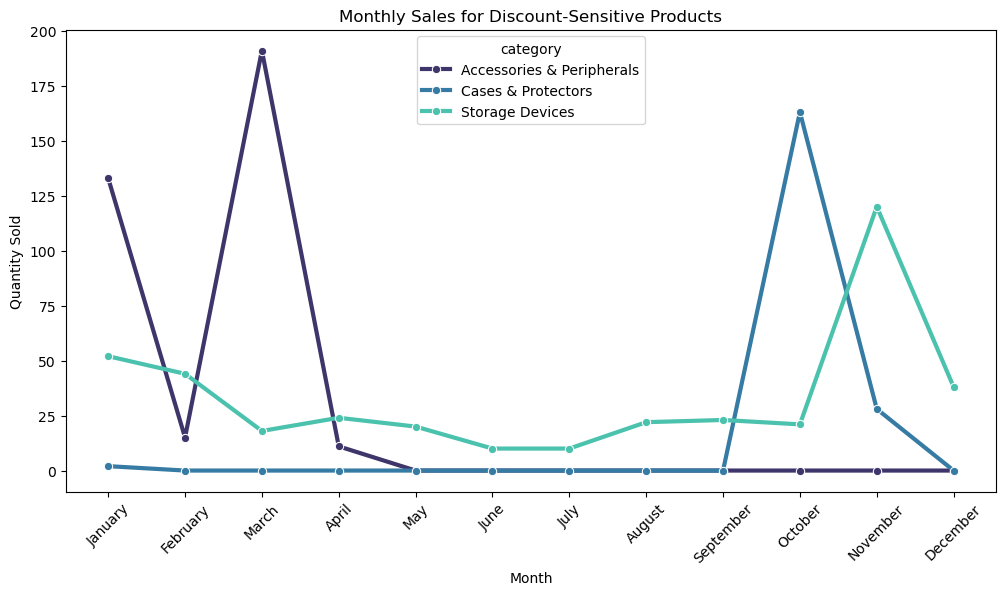

In [68]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_patterns, x='month', y='qty', hue='category', marker="o", palette='mako', linewidth=3)
plt.title('Monthly Sales for Discount-Sensitive Products')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.ylabel('Quantity Sold')
plt.savefig("discount_sensitive_products", dpi=300)
plt.show()

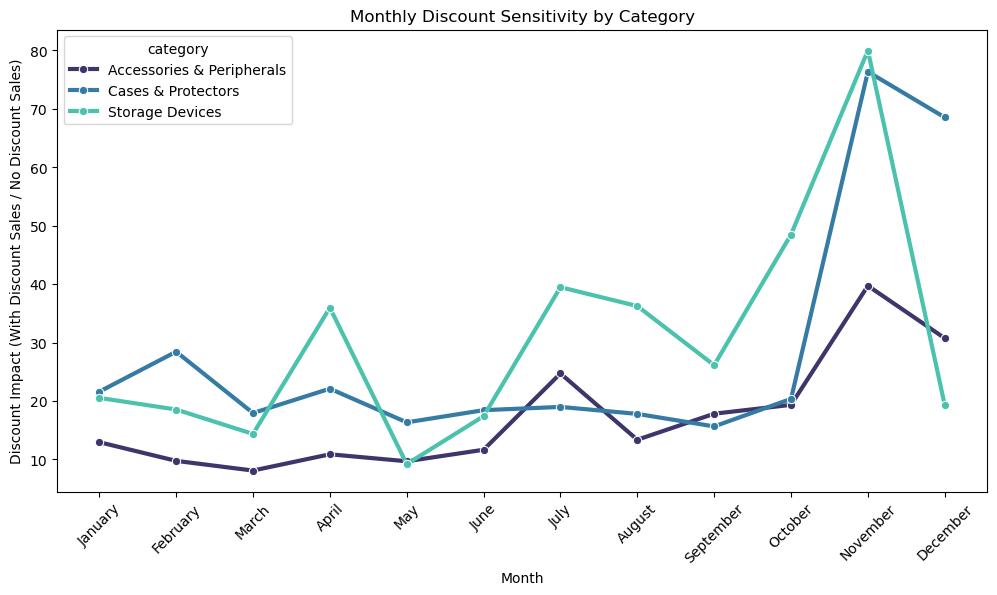

In [69]:
# First, calculate discount impact by category and month
monthly_discount_impact = ol_cl.groupby(['category', 'month', 'has_discount']).agg({
    'qty': 'sum'
}).unstack().fillna(0)

# Calculate the impact ratio
monthly_discount_impact['discount_impact'] = monthly_discount_impact[('qty', True)] / (monthly_discount_impact[('qty', False)] + 1)
monthly_discount_impact = monthly_discount_impact['discount_impact'].reset_index()

# Filter for your discount-sensitive categories
sensitive_categories = ol_cl[ol_cl['sku'].isin(discount_sensitive.index)]['category'].unique()
monthly_discount_impact = monthly_discount_impact[monthly_discount_impact['category'].isin(sensitive_categories)]

# Now plot it
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_discount_impact, x='month', y='discount_impact', hue='category', marker="o", palette='mako', linewidth=3)
plt.title('Monthly Discount Sensitivity by Category')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.ylabel('Discount Impact (With Discount Sales / No Discount Sales)')
plt.savefig("discount_impact_by_month", dpi=300)
plt.show()

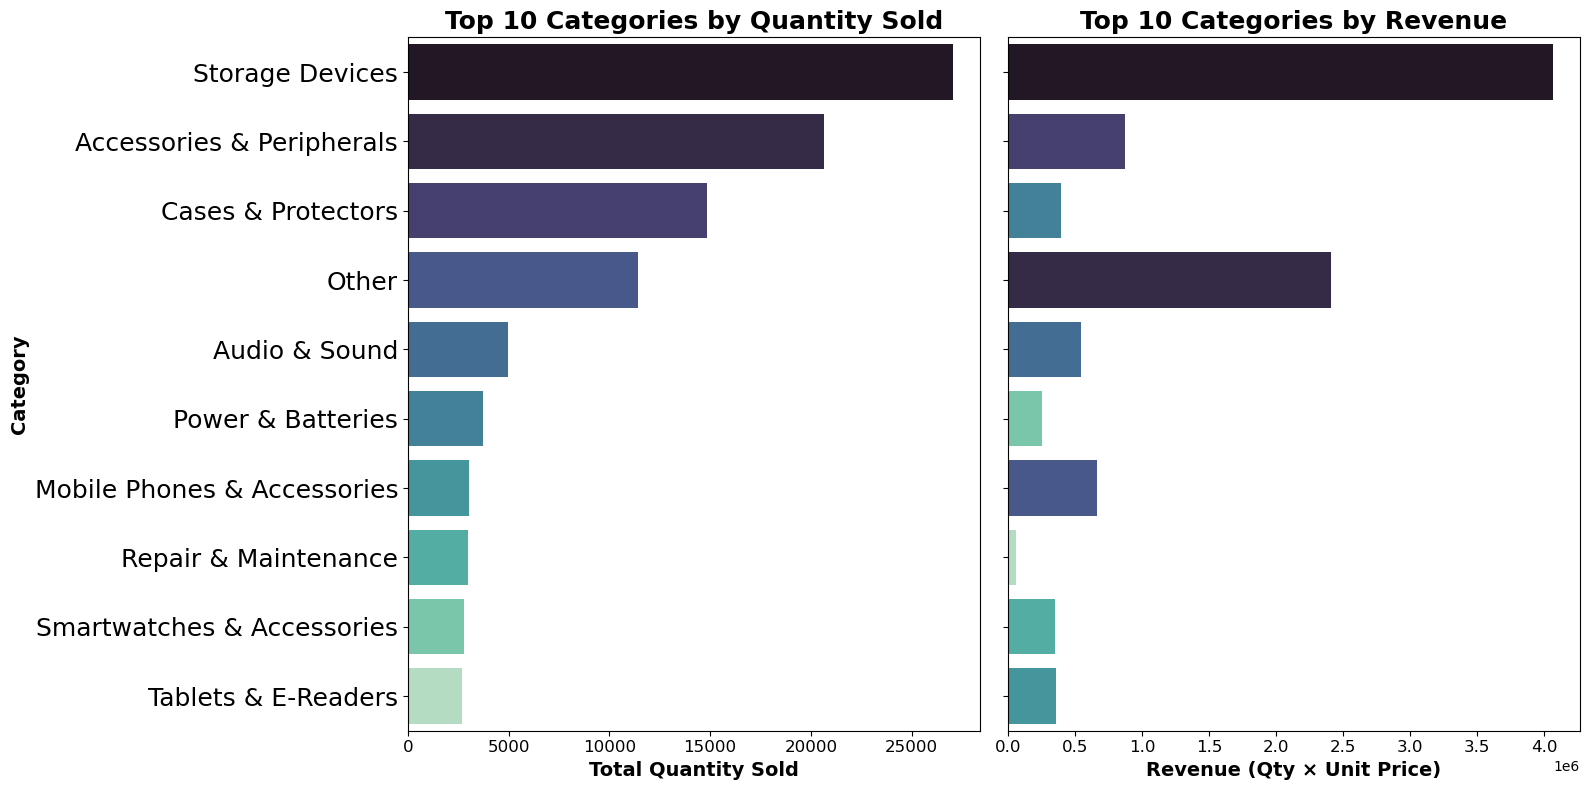

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate the correct revenue for each item
# Instead of using total_paid, multiply quantity by unit price
ol_cl['item_revenue'] = ol_cl['qty'] * ol_cl['unit_price']

# Step 2: Group by category and sum up quantities and revenues
category_stats = ol_cl.groupby('category').agg({
    'qty': 'sum',                # Total quantity for each category
    'item_revenue': 'sum'        # Total revenue for each category
}).reset_index()

# Step 3: Get the top 10 categories by quantity
top_qty_categories = category_stats.sort_values(by='qty', ascending=False).head(10)['category']

# Step 4: Filter to only include those top 10 categories
top_categories = category_stats[category_stats['category'].isin(top_qty_categories)]

# Step 5: Create the visualization with two charts side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Font settings
title_font = {'fontsize': 18, 'fontweight': 'bold'}
label_font = {'fontsize': 14, 'fontweight': 'bold'}
tick_fontsize = 12
category_fontsize = 18

# Step 6: First chart - Quantity by category
sns.barplot(
    data=top_categories.sort_values(by='qty', ascending=False), 
    y='category', 
    x='qty', 
    ax=axes[0], 
    palette='mako'
)
axes[0].set_xlabel('Total Quantity Sold', **label_font)
axes[0].set_ylabel('Category', **label_font)
axes[0].set_title('Top 10 Categories by Quantity Sold', **title_font)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)
for label in axes[0].get_yticklabels():
    label.set_fontsize(category_fontsize)

# Step 7: Second chart - Revenue by category (using the correct calculation)
sns.barplot(
    data=top_categories.sort_values(by='item_revenue', ascending=False), 
    y='category', 
    x='item_revenue', 
    ax=axes[1], 
    palette='mako'
)
axes[1].set_xlabel('Revenue (Qty × Unit Price)', **label_font)
axes[1].set_ylabel('')  # No need for duplicate y-axis label
axes[1].set_title('Top 10 Categories by Revenue', **title_font)
axes[1].tick_params(axis='both', labelsize=tick_fontsize)

# Step 8: Make it look nice and save
plt.tight_layout()
plt.savefig("top_categories_by_qty_and_revenue", dpi=300)
plt.show()

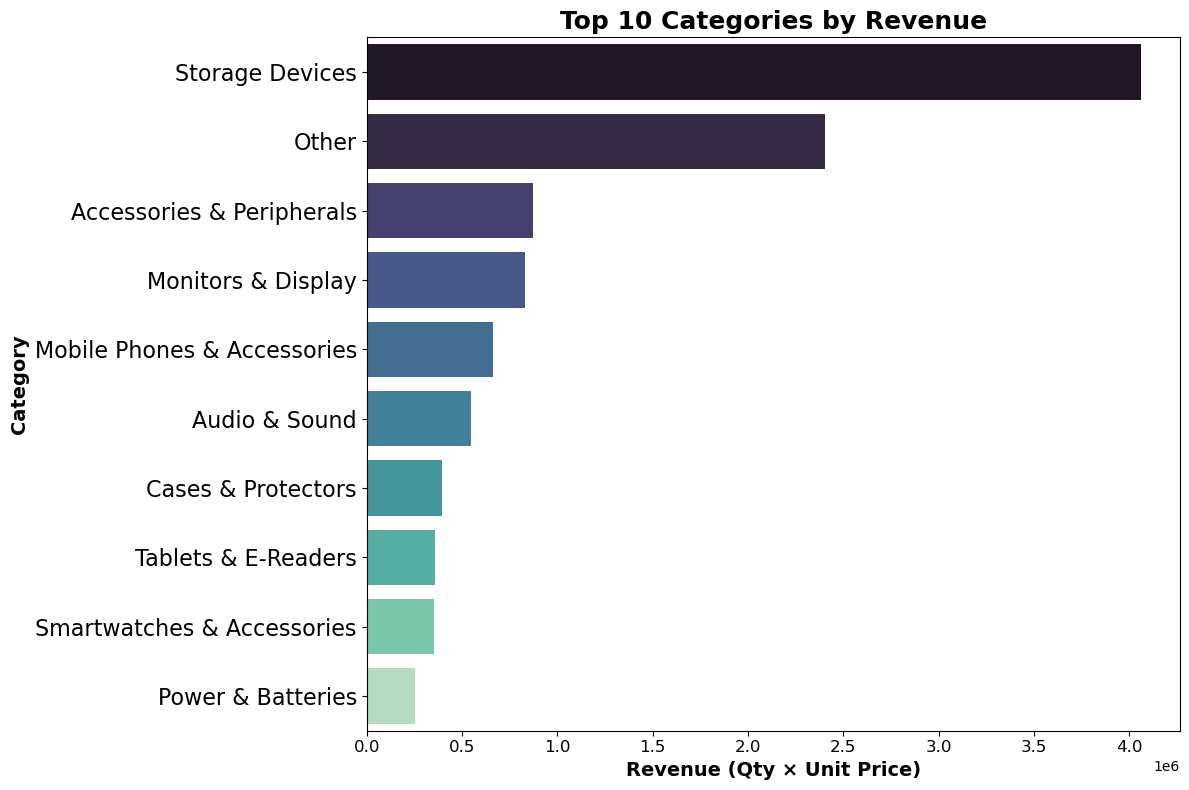

Top 10 Categories by Revenue:
                       category  item_revenue
14              Storage Devices    4063727.83
10                        Other    2405784.39
0     Accessories & Peripherals     873921.84
7            Monitors & Display     828795.30
6   Mobile Phones & Accessories     660942.35
1                 Audio & Sound     547387.35
4            Cases & Protectors     396770.69
15          Tablets & E-Readers     358858.95
13   Smartwatches & Accessories     350720.35
11            Power & Batteries     254229.59


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correct revenue for each item
ol_cl['item_revenue'] = ol_cl['qty'] * ol_cl['unit_price']

# Group by category and sum up revenues
revenue_by_category = ol_cl.groupby('category')['item_revenue'].sum().reset_index()

# Sort by revenue in descending order and get top 10
top_revenue_categories = revenue_by_category.sort_values(by='item_revenue', ascending=False).head(10)

# Create a single bar chart for top categories by revenue
plt.figure(figsize=(12, 8))

# Create the bar plot
sns.barplot(
    data=top_revenue_categories,
    y='category',
    x='item_revenue',
    palette='mako'
)

# Add labels and title
plt.xlabel('Revenue (Qty × Unit Price)', fontsize=14, fontweight='bold')
plt.ylabel('Category', fontsize=14, fontweight='bold')
plt.title('Top 10 Categories by Revenue', fontsize=18, fontweight='bold')
plt.tick_params(axis='both', labelsize=12)

# Make y-axis category labels larger
for label in plt.gca().get_yticklabels():
    label.set_fontsize(16)

# Make it look nice and save
plt.tight_layout()
plt.savefig("top_categories_by_revenue", dpi=300)
plt.show()

# Also print the data as a table for reference
print("Top 10 Categories by Revenue:")
print(top_revenue_categories)

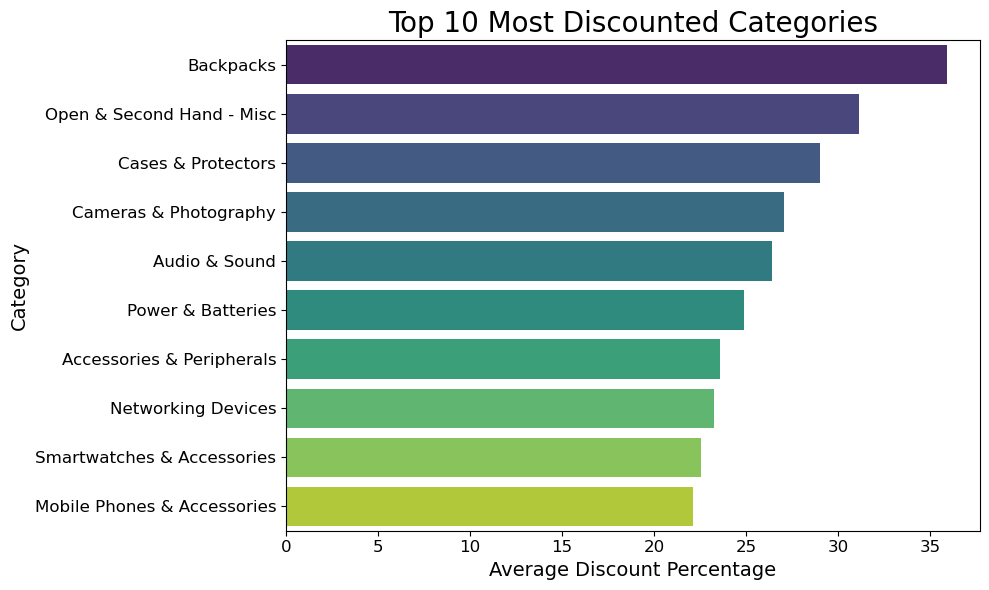

In [72]:
##### TOP PRODUCTS WITH MOST DISCOUNTS ######

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# average discount percentage by category
avg_discount_by_category = ol_cl.groupby('category')['discount_pct'].mean().reset_index()

top_discounted_categories = avg_discount_by_category.sort_values(by='discount_pct', ascending=False).head(10)

#plot

plt.figure(figsize=(10, 6))
sns.barplot(data=top_discounted_categories, x='discount_pct', y='category', palette='viridis')
plt.title('Top 10 Most Discounted Categories', fontsize=20)
plt.xlabel('Average Discount Percentage', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.savefig("most_discount_category")
plt.show()



In [73]:
ol_cl["category"].value_counts()

category
Storage Devices                22516
Accessories & Peripherals      17398
Cases & Protectors             13967
Other                          10547
Audio & Sound                   4476
Power & Batteries               3558
Mobile Phones & Accessories     2880
Repair & Maintenance            2835
Smartwatches & Accessories      2688
Tablets & E-Readers             2452
Monitors & Display              1862
Open & Second Hand - Misc        801
Backpacks                        597
Networking Devices               589
Cameras & Photography            341
Laptops & Computers              238
Name: count, dtype: int64

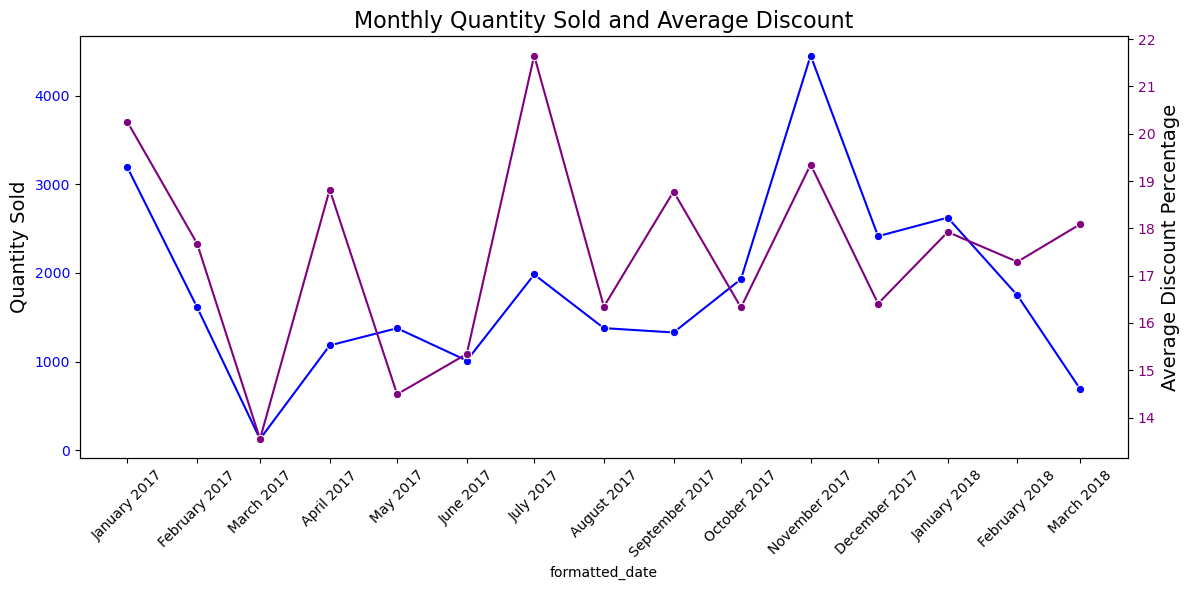

In [74]:
##### MONTHLY QUANTITY SOLD AND AVG DISCOUNT BY CATEGORY ######

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# choose category. you can change the category name
category_data = ol_cl[ol_cl['category'] == 'Storage Devices']

# date column to datetime format 
category_data['date'] = pd.to_datetime(category_data['date'])

# new date column as year and month
category_data['formatted_date'] = category_data['date'].dt.to_period('M')

# groupping by formatted date and aggreagate
monthly_category = category_data.groupby('formatted_date').agg(qty=('qty', 'sum'), discount_pct=('discount_pct', 'mean')).reset_index()

# convert formatted_date back to datetime 
monthly_category['formatted_date'] = monthly_category['formatted_date'].dt.to_timestamp()

#line plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot quantity sold
sns.lineplot(data=monthly_category, x='formatted_date', y='qty', marker='o', ax=ax1, color='b')
ax1.set_ylabel('Quantity Sold', fontsize=14)
ax1.set_title('Monthly Quantity Sold and Average Discount', fontsize=16)
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(monthly_category['formatted_date'])
ax1.set_xticklabels(monthly_category['formatted_date'].dt.strftime('%B %Y'), rotation=45)

#second y-axis for average discount
ax2 = ax1.twinx()
sns.lineplot(data=monthly_category, x='formatted_date', y='discount_pct', marker='o', ax=ax2, color='purple')
ax2.set_ylabel('Average Discount Percentage', fontsize=14)
ax2.tick_params(axis='y', labelcolor='purple')

plt.tight_layout()
plt.savefig("qty_discount_monthly_storage_devices", dpi=300)
plt.show()


In [75]:
discount_df = ol_cl[["discount_pct", "category", "qty", "total_paid", "sku","unit_price","date"]].copy()

discount_df["discount_category"] = ""

discount_df.loc[discount_df.discount_pct < 0, "discount_category"] = "No discount" 
discount_df.loc[discount_df.discount_pct == 0, "discount_category"] = "No discount" 
discount_df.loc[(discount_df.discount_pct > 0) & (discount_df.discount_pct <= 10), "discount_category"] = "Up to 10"
discount_df.loc[(discount_df.discount_pct > 10) & (discount_df.discount_pct <= 20), "discount_category"] = "Up to 20"
discount_df.loc[(discount_df.discount_pct > 20) & (discount_df.discount_pct <= 30), "discount_category"] = "Up to 30"
discount_df.loc[(discount_df.discount_pct > 30) & (discount_df.discount_pct <= 40), "discount_category"] = "Up to 40"
discount_df.loc[(discount_df.discount_pct > 40) & (discount_df.discount_pct <= 50), "discount_category"] = "Up to 50"
discount_df.loc[(discount_df.discount_pct > 50), "discount_category"] = "More than 50"



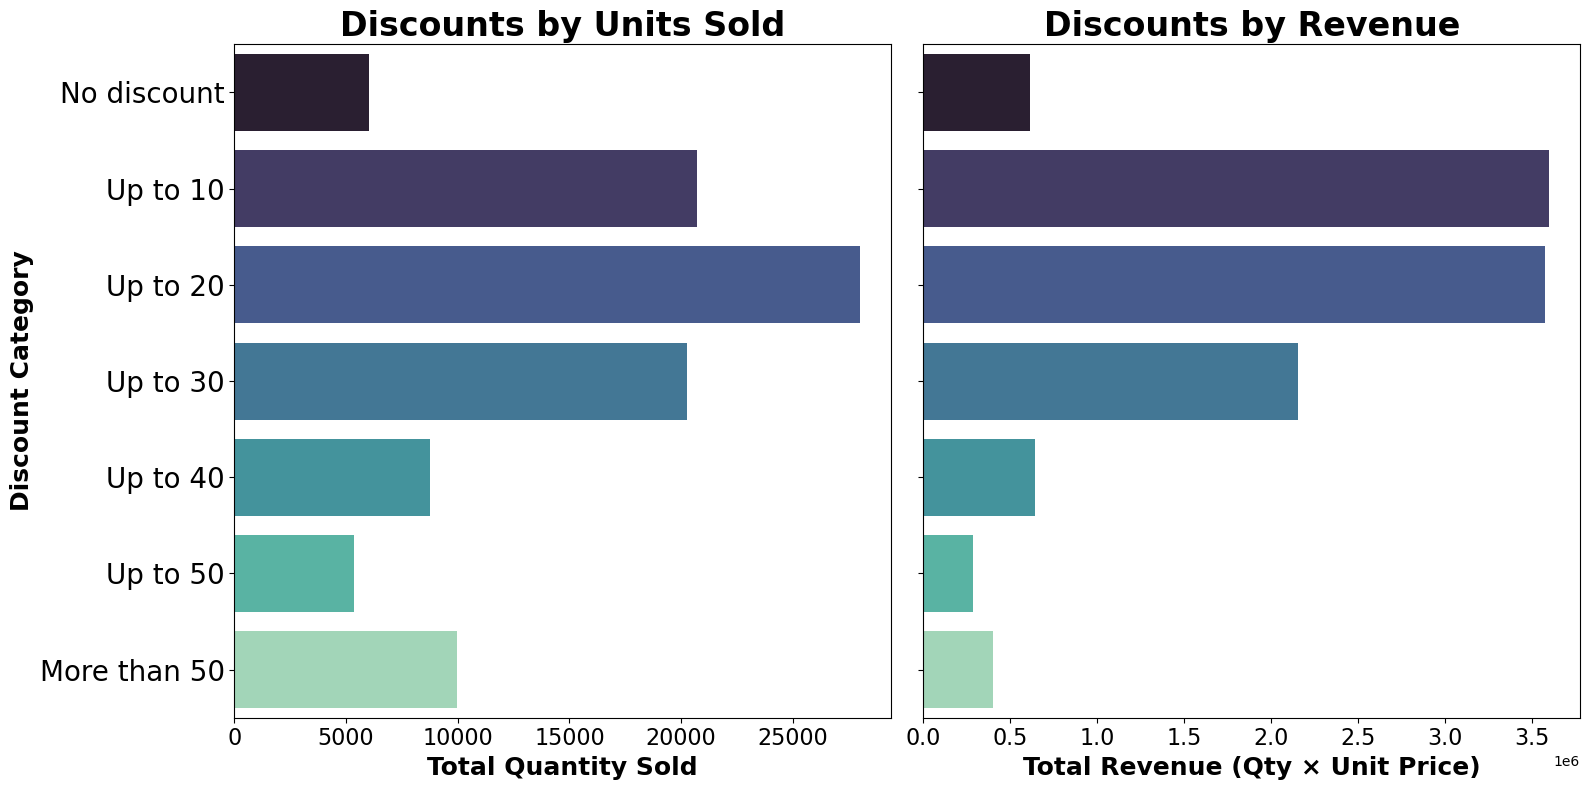

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the discount order categories
discount_order = ["No discount", "Up to 10", "Up to 20", "Up to 30", 
                 "Up to 40", "Up to 50", "More than 50"]

# Set discount_category as categorical with specific order
discount_df["discount_category"] = pd.Categorical(discount_df["discount_category"], 
                                               categories=discount_order, ordered=True)


# Calculate correct revenue as qty * unit_price
discount_df["correct_revenue"] = discount_df["qty"] * discount_df["unit_price"]

# Group by discount_category and calculate sums
discount_summary = discount_df.groupby("discount_category", as_index=False).agg({
    "qty": "sum", 
    "correct_revenue": "sum"  # Use the new correct revenue column
})

# Sort by quantity for the first plot
discount_qty = discount_summary.sort_values(by="qty", ascending=False)

# Setting up figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Font size settings
title_font = {'fontsize': 24, 'fontweight': 'bold'}
label_font = {'fontsize': 18, 'fontweight': 'bold'}
tick_fontsize = 16
category_fontsize = 20

# Bar plot for quantity sold
sns.barplot(data=discount_qty, 
            y='discount_category', x='qty', ax=axes[0], palette='mako')
axes[0].set_xlabel('Total Quantity Sold', **label_font)
axes[0].set_ylabel('Discount Category', **label_font)
axes[0].set_title('Discounts by Units Sold', **title_font)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)
for label in axes[0].get_yticklabels():
    label.set_fontsize(category_fontsize)

# Bar plot for correct revenue
# Sort by correct_revenue for the second plot
discount_revenue = discount_summary.sort_values(by="correct_revenue", ascending=False)
sns.barplot(data=discount_revenue, 
            y='discount_category', x='correct_revenue', ax=axes[1], palette='mako')
axes[1].set_xlabel('Total Revenue (Qty × Unit Price)', **label_font)
axes[1].set_ylabel('')  # Remove redundant y-axis label
axes[1].set_title('Discounts by Revenue', **title_font)
axes[1].tick_params(axis='both', labelsize=tick_fontsize)

# Display and save
plt.tight_layout()
plt.savefig("discount_categories_qty_revenue_corrected", dpi=300)
plt.show()

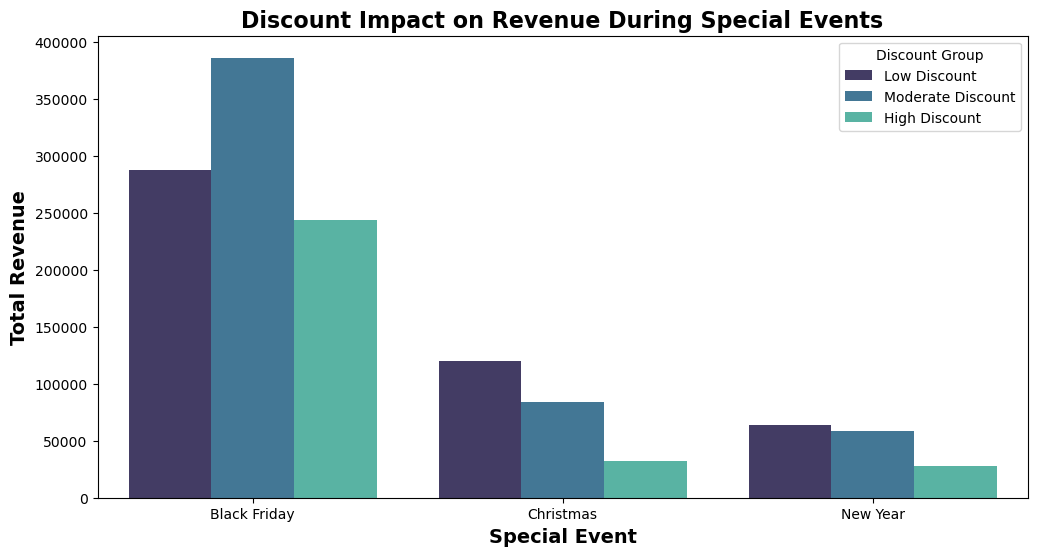

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'discount_pct' column exists and has no negative values
discount_df["discount_pct"] = discount_df["discount_pct"].clip(lower=0)

# Categorize discounts into three equal groups (terciles)
discount_df["discount_group"] = pd.qcut(discount_df["discount_pct"], q=3, labels=["Low Discount", "Moderate Discount", "High Discount"])

# Convert date column to datetime if not already
discount_df["date"] = pd.to_datetime(discount_df["date"])

# Define special events (adjust based on your data)
special_events = {
    "Black Friday": ("2017-11-24", "2017-11-27"),
    "Christmas": ("2017-12-20", "2017-12-26"),
    "New Year": ("2017-12-30", "2018-01-02")
}

# Calculate revenue as qty * unit_price
discount_df["revenue"] = discount_df["qty"] * discount_df["unit_price"]

# Filter data for special events and analyze revenue
event_results = []
for event, (start, end) in special_events.items():
    event_data = discount_df[(discount_df["date"] >= start) & (discount_df["date"] <= end)]
    
    if not event_data.empty:
        event_summary = event_data.groupby("discount_group").agg({"revenue": "sum", "qty": "sum"}).reset_index()
        event_summary["event"] = event  # Add event name
        event_results.append(event_summary)

# Combine event results
event_analysis = pd.concat(event_results, ignore_index=True)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=event_analysis, x="event", y="revenue", hue="discount_group", palette="mako")
plt.xlabel("Special Event", fontsize=14, fontweight="bold")
plt.ylabel("Total Revenue", fontsize=14, fontweight="bold")
plt.title("Discount Impact on Revenue During Special Events", fontsize=16, fontweight="bold")
plt.legend(title="Discount Group")
plt.savefig("discount_impact_special_days")
plt.show()
